In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import jv
from scipy.optimize import fsolve

## Contour line related
Here we construct the contour line first. Then we scale and translate the coordinate according to the fill ratio of the tank.

In [3]:
z_min, z_max = 0.0, 1.0
n_inner, n_outer = 2, 100

def r_inner(z):
    if type(z) == float:
        return 0.0
    elif type(z) == list:
        return [0.0] * len(z)
    elif type(z) == np.ndarray:
        return np.zeros_like(z)
    else:
        print("Error type")
        return None

def r_outer(z):
    return np.sqrt(0.25 - (z-0.5)**2)

out = np.full((max(n_inner, n_outer), 4), fill_value=np.nan)
z_inner = np.linspace(z_min, z_max, n_inner)
z_outer = np.linspace(z_min, z_max, n_outer)

out[0: z_inner.shape[0], 0:2] = np.vstack((z_inner, r_inner(z_inner))).T
out[0: z_outer.shape[0], 2:4] = np.vstack((z_outer, r_outer(z_outer))).T

np.savetxt("test.txt", out)

In [22]:
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import SloshFunc as sf
import pandas as pd

def read_dict(fname: str):
    data_dict = {}
    with open(fname, "r") as file:
        for line in file:
            key, val = line.split(":", 1)
            key, val = key.strip(), val.strip()
            if ("." in val) or ("e" in val):
                data_dict[key] = float(val)
            else:
                data_dict[key] = int(val)

    return data_dict

class Tank:
    def __init__(self, LFR: float, fname = "./test.txt", settings = "./settings.txt", delimiter = " "):
        '''
        The input z coordinate should be in ascending order.

        In this init function, we read in the contour profile, get the interpolater and the boundarys.
        '''
        contours = np.loadtxt(fname, delimiter=delimiter)
        self.z_ic_original, self.r_ic_original = contours[:, 0], contours[:, 1]
        self.z_oc_original, self.r_oc_original = contours[:, 2], contours[:, 3]

        # drop all nans
        self.z_ic_original = self.z_ic_original[~np.isnan(self.z_ic_original)]
        self.r_ic_original = self.r_ic_original[~np.isnan(self.r_ic_original)]
        self.z_oc_original = self.z_oc_original[~np.isnan(self.z_oc_original)]
        self.r_oc_original = self.r_oc_original[~np.isnan(self.r_oc_original)]

        # get the interpolater
        self.IC_original = interp1d(self.z_ic_original, self.r_ic_original)
        self.OC_original = interp1d(self.z_oc_original, self.r_oc_original)

        # get the boundary
        self.bIC = np.array([np.min(self.r_ic_original), np.max(self.r_ic_original),
                             np.min(self.z_ic_original), np.max(self.z_ic_original)])
        
        self.bOC = np.array([np.min(self.r_oc_original), np.max(self.r_oc_original),
                             np.min(self.z_oc_original), np.max(self.z_oc_original)])
        
        # get the non-dimensional quantities
        self.LFR = LFR
        self.get_geometry(LFR)

        # get the computational settings
        self.settings = read_dict(settings)




    def get_geometry(self, LFR: float):
        '''
        Here we scale the geometry according the fill ratio. The fill ratio is the level of the 
        surface / the entire height of the geometry
        '''
        r_ic_file = self.IC_original # inner contour, unscaled
        r_oc_file = self.OC_original # outer contour, unscaled
        b_ic_file = self.bIC
        b_oc_file = self.bOC

        # Here we do not scale the geometry based on the RFac and ZFac, which is originally done in the MATLAB code
        RFac, ZFac = 1.0, 1.0
        self.RFac, self.ZFac = RFac, ZFac
        b_ens_scaled_origin = np.array([min(b_ic_file[0], b_oc_file[0]) * RFac, max(b_ic_file[1], b_oc_file[1]) * RFac,
                                        max(b_ic_file[2], b_oc_file[2]) * ZFac, min(b_ic_file[3], b_oc_file[3]) * ZFac])
        r_ic_scaled_origin = lambda z: r_ic_file(z/ZFac) * RFac
        r_oc_scaled_origin = lambda z: r_oc_file(z/ZFac) * RFac

        H_tank = LFR * (b_ens_scaled_origin[-1] - b_ens_scaled_origin[-2])
        H_origin = H_tank + b_ens_scaled_origin[-2]

        # perform integration to get the fluid volume and the gravity center
        breaks = np.unique(np.concatenate((self.z_ic_original, self.z_oc_original))) * ZFac
        breaks = np.clip(breaks, b_ens_scaled_origin[-2], H_origin)
        limit = breaks.shape[0] * 5

        fluid_volume = integrate.quad(lambda z: np.pi*((r_oc_scaled_origin(z))**2 - (r_ic_scaled_origin(z))**2), 
                                      b_ens_scaled_origin[-2], H_origin, points = breaks, limit = limit)[0]
        z_CM = integrate.quad(lambda z: z * ((r_oc_scaled_origin(z))**2 - (r_ic_scaled_origin(z))**2), 
                              b_ens_scaled_origin[-2], H_origin, points = breaks, limit = limit)[0]\
              /integrate.quad(lambda z: ((r_oc_scaled_origin(z))**2 - (r_ic_scaled_origin(z))**2),
                              b_ens_scaled_origin[-2], H_origin, points = breaks, limit = limit)[0]
        
        b_ens_scaled_CM = b_ens_scaled_origin - np.array([0.0, 0.0, z_CM, z_CM])
        r_ic_scaled_CM = lambda z: r_ic_scaled_origin(z+z_CM)
        r_oc_scaled_CM = lambda z: r_oc_scaled_origin(z+z_CM)

        # fluid height with respect to the center of mass, measured in the mass-center coordinate
        self.L = H_origin - z_CM

        # scaling parameters:
        self.a = r_oc_scaled_CM(self.L)
        self.epsilon = r_ic_scaled_CM(self.L)
        self.L_a = self.L / self.a

        # the non-dimensional contours (the inputs of the contours are non-dimensional coordinates, the outputs
        # are also non-dimensional)
        self.R_ic_CM = lambda Z: r_ic_scaled_CM(Z * self.a) / self.a
        self.R_oc_CM = lambda Z: r_oc_scaled_CM(Z * self.a) / self.a

        # save other quantities
        self.z_CM = z_CM
        self.fluid_volume = fluid_volume
        self.bens = b_ens_scaled_CM
        self.intb = self.bens / self.a
        self.H_tank = H_tank
        self.H_origin = H_origin
 
    def calculate(self):
        self.A, self.B, self.c_k, self.lambda_k, self.Bzeros = \
                                    sf.core(self.settings["N"], self.settings["M"], 
                                    self.settings["nsteps"], self.intb, self.epsilon,
                                    self.L_a, self.R_ic_CM, self.R_oc_CM)

    def compute_mechanical_analogies(self):
        epsilon = self.epsilon
        L_a = self.L_a
        a = self.a
        R_ic = self.R_ic_CM
        R_oc = self.R_oc_CM
        intb = self.intb * a # convert intb to DIMENSIONAL form
        N = self.settings["N"]
        M = self.settings["M"]
        g = self.settings["g"]
        rho = self.settings["rho"]
        flvol = self.fluid_volume
        H = self.H_tank
        selm = self.settings["SpringModeSpinner"]
        lambda_k = self.lambda_k
        c_k = self.c_k
        Bzeros = self.Bzeros


        # Derived parameters
        B = np.zeros((N, N))
        s_n = np.zeros(N)
        phi_a = np.zeros(N)

        # integration break points
        breaks = (np.unique(np.concatenate((self.z_ic_original, self.z_oc_original))) * self.ZFac - self.z_CM) / self.a
        breaks = np.clip(breaks, intb[2]/a, L_a)
        limit = breaks.shape[0] * 5
        
        # calculate the derived parameters
        for n in range(N):
            integrand1 = lambda z: (z-intb[2]/a)*R_oc(z)*sf.phi(n+1,M,R_oc(z),z,Bzeros,L_a)
            integrand2 = lambda z: (z-intb[2]/a)*R_ic(z)*sf.phi(n+1,M,R_ic(z),z,Bzeros,L_a)
            s_n[n] = integrate.quad(integrand1, intb[2]/a, L_a, limit=limit, points=breaks)[0]\
                    -integrate.quad(integrand2, intb[2]/a, L_a, limit=limit, points=breaks)[0]
            phi_a[n] = 0

            for k in range(N):
                phi_a[n] =  phi_a[n] + c_k[k,n]*sf.phi(k+1,M,R_oc(L_a),L_a,Bzeros,L_a)

            for m in range(n, N):
                B[n,m] = sf.Bint(n+1,m+1,M,Bzeros,epsilon)

        # fill the lower-triangle of B
        B = B + B.T - np.eye(N) * B

        self.B_ma, self.s_n, self.phi_a = B, s_n, phi_a
        
        # get the derived pendulum parameters
        K, omega_k, Vc, M_k, L_k, H_k, CM_k, fluid_mass, c_k, lambda_k, I_sort = \
            sf.derivedparams(rho, flvol, H, c_k, lambda_k, g, L_a*a, a, B, s_n, phi_a, intb, selm)

        self.Km, self.omega_k, self.characteristic_velocity, self.M_k, self.L_k, self.H_k, self.CM_k, self.c_k, self.lambda_k, self.I_modesSorting = \
            K, omega_k, Vc, M_k, L_k, H_k, CM_k, c_k, lambda_k, I_sort
        
        self.K_k, self.H_k_spring = sf.pendulum2spring(M_k, L_k, g, H_k)

    def report(self):
        '''
        Report the mechanical characteristics in pandas csv format
        '''
        selm = self.settings["SpringModeSpinner"]
        self.pendulum_table = pd.DataFrame(
            {
                "Mass": self.M_k[0:selm+1],
                "Length": self.L_k[0:selm+1],
                "Height": self.H_k[0:selm+1],
                "CM": self.CM_k[0:selm+1]
            },
            index=["Fixed mass"]+list(range(1, selm+1))
        )

        self.spring_table = pd.DataFrame(
            {
                "Mass": self.M_k[0:selm+1],
                "Height": self.H_k_spring[0:selm+1],
                "K": self.K_k[0:selm+1]
            },
            index=["Fixed mass"]+list(range(1, selm+1))
        )

        self.freq_table = pd.DataFrame(
            {
                "lambda": self.lambda_k,
                "K": self.Km,
                "Omega": self.omega_k
            }
        ).transpose()

        display(self.pendulum_table)
        display(self.spring_table)
        display(self.freq_table)




In [23]:
tank = Tank(LFR = 0.65, fname = "RP1_Tank_SaturnV.txt", delimiter=",")
tank.calculate()

100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


In [24]:
tank.compute_mechanical_analogies()

d:\Research and Courses\Graduate-II\Orienspace-Intern\Sloshing\Code\slosh_py\SloshFunc.py:232: RuntimeWarning: divide by zero encountered in divide
  K_k = M_k*g/L_k


In [25]:
tank.report()

,Mass,Length,Height,CM
Fixed mass,347013.803406,0.000000,4.877075,0.000000
1,179106.195119,2.761719,5.907723,1.524046
2,5445.577755,0.943310,6.774268,0.388640
3,1298.832187,0.589152,7.115642,0.237551


,Mass,Height,K
Fixed mass,347013.803406,4.877075,inf
1,179106.195119,3.146005,6.362095e+05
2,5445.577755,5.830958,5.663155e+04
3,1298.832187,6.526489,2.162690e+04


,0,1,2,3,4,5,6,7,8,9
lambda,1.821040,5.331439,8.536330,11.706072,1301.097440,14.863809,6001.758214,1.066463e+07,7.006104e+12,-5.656453e+13
K,1.229471,3.599509,5.763285,7.903329,878.433113,10.035269,4052.074034,7.200205e+06,4.730156e+12,-3.818942e+13
Omega,1.884711,3.224833,4.080568,4.778490,50.377889,5.384559,108.199262,4.560979e+03,3.696778e+06,1.050406e+07


In [14]:
np.savetxt("./results/A.txt", tank.A, fmt="%8.4f")
np.savetxt("./results/B.txt", tank.B, fmt="%8.4f")
np.savetxt("./results/D.txt", tank.lambda_k, fmt="%8.4f")
np.savetxt("./results/V.txt", tank.c_k, fmt="%8.4f")

np.savetxt("./results/B_a.txt", tank.B_ma, fmt="%8.4f")
np.savetxt("./results/s_n.txt", tank.s_n, fmt="%8.4f")
np.savetxt("./results/phi_a.txt", tank.phi_a, fmt="%8.4f")

In [10]:
np.real(tank.lambda_k)

array([-4.62751522e+13,  5.57659603e+12,  8.48944686e+06,  1.66910812e+04,
        1.04943965e+03,  1.85686271e+00,  5.44114432e+00,  1.50165204e+01,
        8.66250857e+00,  1.18443449e+01])

In [12]:
tank.s_n.shape

(10,)

In [15]:
x = np.arange(9).reshape((3,3))
y = np.arange(-9, 0).reshape((3,3))
print(x)
print(y)
np.diag(x).sum()

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[-9 -8 -7]
 [-6 -5 -4]
 [-3 -2 -1]]


12

In [19]:
np.concatenate(([1], np.arange(2, 4)))

array([1, 2, 3])

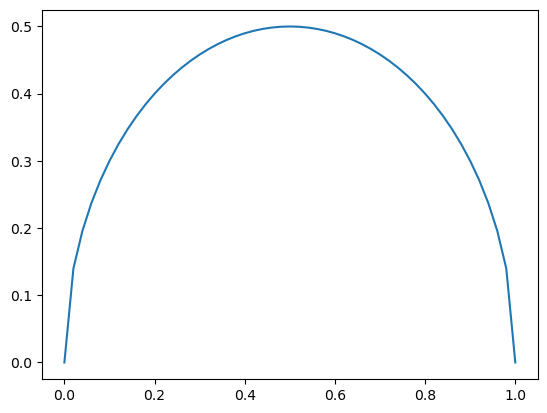

In [16]:
z = np.linspace(0.0, 1.0, 51)
plt.plot(z, tank.OC_original(z))

## Bessel function module

In [55]:
def dBesselj(x, n):
    return (jv(n-1, x) - jv(n+1, x)) / 2.0

def dBesselzero(N: int):
    Bzeros = []
    order = 1

    while order <= N:

        if order == 1:
            stepB = 1.8
        else:
            stepB = Bzeros[-1] + np.pi

        Bzero = fsolve(dBesselj, stepB, args = (1))[0]

        if order == 1:
            Bzeros.append(Bzero)
        else: # we have to check if there's duplicated root
            mindiff = np.max(np.abs(np.array(Bzeros) - Bzero))
            if mindiff < 1e-5 * max(Bzeros):
                pass
            else:
                Bzeros.append(Bzero)
        
        order = len(Bzeros) + 1

    # sort the Bzeros array in ascending order
    Bzeros = np.array(Bzeros)

    return np.sort(Bzeros)


In [56]:
Bzeros = dBesselzero(10)

## The integral related to the shape

In [123]:
eps = 1e-10

def isinside(r, z, r_ic, r_oc):
    return (r >= r_ic(z)) * (r <= r_oc(z))


def Aint(r,z,m,n,M,Bzeros,L,r_ic, r_oc):
    '''
    We only get the integrand for a_mn here. 
    '''

    r = np.clip(r, eps, np.inf)

    if m > M:
        jm = Bzeros[m-M-1]
    
    if n > M:
        jn = Bzeros[n-M-1]

    if m <= M and n <= M :
        I   = (np.abs((2*m-1)*(2*n-1) + 1)* r**(2*n+2*m-4))*r
    elif m <= M and n > M:    
        I   = ((2*m-1)*r**(2*m-2)*jn*dBesselj(jn*r, 1)*np.exp(jn*(z-L)) +\
                r**(2*m-3)*jv(1, jn*r)*np.exp(jn*(z-L)))*r
    elif m > M and n > M:
        I   = (r*jn*jm*dBesselj(jn*r, 1)*dBesselj(jm*r,1) + \
               r**(-1)* jv(1,jn*r)*jv(1,jm*r) + \
               r*jn*jm*jv(1,jn*r)*jv(1, jm*r))*\
               np.exp((jn + jm)*(z-L))

    return I * isinside(r, z, r_ic, r_oc)

def Bint(m,n,M,Bzeros,r_cm):
    '''

    '''
    if m > M:
        jm = Bzeros[m-M-1]
    
    if n > M:
        jn = Bzeros[n-M-1]

    if n <= M and m <= M:
        bmn = (1 - r_cm**(2*n+2*m))/(2*n+2*m)
    elif n > M and m > M and m != n:
        bmn = (jm*r_cm*jv(1,jn*r_cm)*dBesselj(jm*r_cm,1) -\
            jn*r_cm*jv(1,jm*r_cm)*dBesselj(jn*r_cm,1))/\
            (jm**2 - jn**2)
    elif n > M and m > M and m == n:
        bmn = ((jn**2-1)*jv(1,jn)**2 -\
            (jn*r_cm*dBesselj(jn*r_cm,1))**2 -\
            (jn**2*r_cm**2-1)*jv(1,jn*r_cm)**2)/\
            (2*jn**2)
    elif n > M and m == 1:
        bmn = 1/jn**3 * (jn*jv(1,jn) -\
            jn*r_cm*jv(1,jn*r_cm) +\
            jn**2*r_cm**2*dBesselj(jn*r_cm, 1))
        
    elif n > M and m <= M:
        bmn = 1/jn**2*((2*m-1)*jv(1,jn) -\
            r_cm**(2*m-1)*abs((2*m-1)*jv(1,jn*r_cm) -\
            jn*r_cm*dBesselj(jn*r_cm, 1)) - \
            4*m*(m-1)*Bint(m-1,n,M,Bzeros,r_cm))

    return bmn


def simp2D(func,a,b,c,d,NX,NY):
    NX = int(2*np.ceil(NX/2))
    NY = int(2*np.ceil(NY/2))

    hx = (b-a)/NX
    hy = (d-c)/NY

    xg = np.linspace(a, b, NX+1)
    yg = np.linspace(c, d, NY+1)
    xxg, yyg = np.meshgrid(xg, yg)

    U = func(xxg, yyg).T

    s1 = U[0,0] + U[0,NY] + U[NX,0] + U[NX,NY]

    ixo = slice(1,NX,2)
    ixe = slice(2,NX-1,2)
    iyo = slice(1,NY,2)
    iye = slice(2,NY-1,2)

    s2 = 2.0 * (np.sum(U[0, iye]) + np.sum(U[NX, iye]) + np.sum(U[ixe, 0]) + np.sum(U[ixe, NY]))
    s3 = 4.0 * (np.sum(U[0, iyo]) + np.sum(U[NX, iyo]) + np.sum(U[ixo, 0]) + np.sum(U[ixo, NY]))

    s4 = 16.0 * np.sum(U[ixo, iyo]) + 4.0 * np.sum(U[ixe, iye])
    s5 = 8.0 * np.sum(U[ixe, iyo]) + 8.0 * np.sum(U[ixo, iye])

    return (s1+s2+s3+s4+s5)*hx*hy/9.0

In [119]:
def simp2D_test(func,a,b,c,d,NX,NY):
    NX = int(2*np.ceil(NX/2))
    NY = int(2*np.ceil(NY/2))

    hx = (b-a)/NX
    hy = (d-c)/NY

    xg = np.linspace(a, b, NX+1)
    yg = np.linspace(c, d, NY+1)
    xxg, yyg = np.meshgrid(xg, yg)

    U = func(xxg, yyg).T

    s1 = U[0,0] + U[0,NY] + U[NX,0] + U[NX,NY]
    print(s1)

    ixo = slice(1,NX,2)
    ixe = slice(2,NX-1,2)
    iyo = slice(1,NY,2)
    iye = slice(2,NY-1,2)

    s2 = 2.0 * (np.sum(U[0, iye]) + np.sum(U[NX, iye]) + np.sum(U[ixe, 0]) + np.sum(U[ixe, NY]))
    s3 = 4.0 * (np.sum(U[0, iyo]) + np.sum(U[NX, iyo]) + np.sum(U[ixo, 0]) + np.sum(U[ixo, NY]))

    s4 = 16.0 * np.sum(U[ixo, iyo]) + 4.0 * np.sum(U[ixe, iye])
    s5 = 8.0 * np.sum(U[ixe, iyo]) + 8.0 * np.sum(U[ixo, iye])

    return (s1+s2+s3+s4+s5)*hx*hy/9.0, U, xxg, yyg

In [73]:
tank.L_a

0.540940908068139

In [112]:
simp2D(lambda r,z: Aint(r, z, 4, 6, 5, Bzeros, tank.L_a, tank.R_ic_CM, tank.R_oc_CM),
       tank.intb[0], tank.intb[1], tank.intb[-2], tank.L_a, 200, 200)

0.09923126682352296

In [120]:
integral, U, xxg, yyg = simp2D_test(lambda r,z: Aint(r, z, 2, 2, 5, Bzeros, tank.L_a, tank.R_ic_CM, tank.R_oc_CM),
                                    tank.intb[0], tank.intb[1], tank.intb[-2], tank.L_a, 200, 200)

1.0000000000000001e-49


In [122]:
integral

1.6957203766555962

In [121]:
np.savetxt("U.txt", U, fmt="%12.4e")

## Core computation functions

In [129]:
from tqdm import tqdm
from scipy.linalg import eig

def core(N, M, nsteps, bens, e, L, r_ic, r_oc):
    r_min, r_max, z_min = bens[0], bens[1], bens[2]

    Bzeros = dBesselzero(N)

    A = np.zeros((N, N))
    B = np.zeros((N, N))

    for m in tqdm(range(1, N+1)):
        for n in range(m, N+1):
            A[m-1, n-1] = simp2D(lambda r,z: Aint(r,z,m,n,M,Bzeros,L,r_ic,r_oc),
                                 r_min,r_max,z_min,L,nsteps,nsteps)
            B[m-1, n-1] = Bint(m,n,M,Bzeros,e)

    A = (A + A.T) - A * np.eye(N)
    B = (B + B.T) - B * np.eye(N)

    lambda_k, V = eig(A, B)

    return A, B, V, lambda_k, Bzeros

In [125]:
A, B = core(10, 5, 200, tank.intb, tank.epsilon, tank.L_a, tank.R_ic_CM, tank.R_oc_CM)

100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


In [126]:
np.savetxt("A.txt", A, fmt="%8.4f")
np.savetxt("B.txt", B, fmt="%8.4f")

In [128]:


D, V = eig(A, B) # returning right egien vectors, each column is a vector, no normalization is performed
np.savetxt("D.txt", D, fmt="%8.4f")
np.savetxt("V.txt", V, fmt="%8.4f")

## Mechanical Analogy